# GSV intake interface and generators

(JvH 30/3/23)

This notebook tests the GSV reader and plays with different concepts to integrate it into the reader.
In particular, in this branch we developed a new driver for intake to allow including GSV requests into standard intake catalogues to simplify access. Also we play with the concept that what AQUA exchanges is actually iterators and not directly xarray containers. This allows to introduce a lazy structure perfect for streaming working with the GSV reader.

Some of this code only works on our machine `mafalda.polito.it`: LUMI is currently down, and I do not have (yet) a MN4 account.
Since the gsv_interface cannot be yet installed as a module, we assume that it is physically located on disk one directory above the current AQUA directory. If you have MN4 access (or if LUMI is up again) you could easily adapt these examples to work also on those machines (check out the specific catalog entries in catalog/mafalda and adapt the requests to the data which you have in fdb) 

On `mafalda` we have a fdb instance containing some ERA5 data (daily, 2000 to 2020, tp, 2t and psl + monthly z at 500hPa)

### 1. Testing the GSV interface
(you can skip this if you are familiar with it)

In [7]:
import sys
import os
sys.path.append("../gsv_interface")

from gsv.retriever import GSVRetriever

gsv = GSVRetriever()

In [8]:
request = { 'class': 'ea',
    'domain': 'g',
    'type': 'an',
    'stream': 'moda',
    'date': '19910401',
    'levelist': '500',
    'levtype': 'pl',
    'param': '129',
    'expver': '0001',
}
ds = gsv.request_data(request)

Correctly decoded z      on level 500    at 1991-04-01T00:00:00


In [10]:
ds

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, height: 1, time: 1)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height   (height) int64 500
  * time     (time) datetime64[ns] 1991-04-01
Data variables:
    z        (height, time, lat, lon) float64 4.937e+04 4.937e+04 ... 4.881e+04

In [11]:
request = { 
    'class': 'ea',
    'domain': 'g',
    'type': 'an',
    'stream': 'oper',
    'date': '20000401',
    'time': [ '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200','1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'],
    'levtype': 'sfc',
    'step': 0,
    'param': '167',
    'expver': '0001',
}
ds = gsv.request_data(request)
ds

Correctly decoded 2t     on level 0      at 2000-04-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-04-01T14:00:00
Correctly decoded 2t     on level 0     

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, height: 1, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height   (height) int64 0
  * time     (time) datetime64[ns] 2000-04-01 ... 2000-04-01T23:00:00
Data variables:
    2t       (height, time, lat, lon) float64 246.2 246.2 246.2 ... 221.6 221.6

### 2. The new GSV intake driver

This branch contains a brand new GSV driver for intake, developed by AQUA.
It allows to add entries like this into the intake catalog (see `config/mafalda/catalog/ERA5/fdb.yaml`):

```
sources:
    monthly:
        args:
            request:
                class: ea
                date: '20000101'
                domain: g
                expver: '0001'
                levtype: sfc
                param: '167'
                stream: moda
                type: an
            step: M
        description: ''
        driver: gsv
        metadata: {step: 'M'}
    daily:
        args:
            request:
                class: ea
                domain: g
                type: an
                stream: oper
                date: '20000101'
                time: [ '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200','1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300']
                levtype: sfc
                step: '0'
                param: '167'
                expver: '0001'
            step: D
        description: ''
        driver: gsv
        metadata: {}
```

Notice that `date` and `param` will actually be overwritten by the driver, so these are only placeholders (intake also allows 'parameters', I will have to study if we can use that instead).
This can greatly simplify access, since we will need to specify only dates and variable for each source, instead of constructing a full mars/fdb request.


Let's test it. It is enough to do

In [12]:
import intake
import aqua.gsv

to add and register the GSV intake driver. It can now be used directly (notice above that the catalog entry specifies `driver: gsv`)

In [13]:
cat = intake.open_catalog("config/mafalda/catalog.yaml")
ds = cat["ERA5"]["fdb"]["daily"](startdate="20000101", enddate="20000102", var='167')
dd = ds.read()


Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T14:00:00
Correctly decoded 2t     on level 0     

Notice that we passed the arguments `var`, `startdate` and `enddate` to the driver. This will automatically retrieve only that variable for a range of dates.

### 3. Digression - how does the intake driver work?

Let's see the contents of `aqua/gsv/intake_gsv.py`

In [1]:
import os
import sys
import xarray as xr
from intake.source import base

from datetime import datetime
from dateutil.relativedelta import relativedelta

sys.path.append("../gsv_interface")
from gsv.retriever import GSVRetriever

class GSVSource(base.DataSource):
    container = 'xarray'
    name = 'gsv'
    version = '0.0.1'
    partition_access = True

    def __init__(self, request, step, startdate="20200101", enddate="20201201", var='167', metadata=None, **kwargs):
        self._request = request
        self._kwargs = kwargs
        self._dates = make_date_list(startdate, enddate, step=step)
        self._var = var
        self._npartitions = len(self._dates)
        self.gsv = GSVRetriever()
        self._dataset = None
        super(GSVSource, self).__init__(metadata=metadata)

    def _get_schema(self):
        # if self._dataset is None:
        #     self._get_partition(0)
        return base.Schema(
            datashape=None,
            dtype=xr.Dataset,
            #shape=self._dataset.shape,
            shape=None,
            npartitions=self._npartitions,
            extra_metadata={},
        )

    def _get_partition(self, i):
        self._request["date"] = self._dates[i]
        self._request["param"] = self._var
        dataset = self.gsv.request_data(self._request)
        return dataset

    def read(self):
        ds = [self._get_partition(i) for i in range(self._npartitions)]
        ds = xr.concat(ds, dim='time')
        return ds
    
    def to_dask(self):
        return self.read_chunked()


what this does is to a new GSVSource class for intake, derived from `base.DataSource`and overloading the relevant methods. It makes use of a small helper function `make_date_list()` which creates a range of dates.

In [12]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import sys

def make_date_list(start, end, step="M", numsteps=1):

    if step == "M":
        delta = relativedelta(months=numsteps)
    elif step == "D":
        delta = relativedelta(days=numsteps)
    elif step == "H":
        delta = relativedelta(hours=numsteps)
    else:
        sys.exit("step not recognized")        

    start_date = datetime.strptime(start, '%Y%m%d')
    end_date = datetime.strptime(end, '%Y%m%d')

    date_list = []
    current_date = start_date

    while current_date <= end_date:
        date_string = current_date.strftime('%Y%m%d')
        date_list.append(date_string)
        current_date += delta

    return date_list

Having done that, we can register the driver to intake:

In [3]:
import intake
intake.registry.drivers.register_driver('gsv', GSVSource)
list(intake.registry)

['netcdf',
 'opendap',
 'rasterio',
 'remote-xarray',
 'xarray_image',
 'zarr',
 'alias',
 'catalog',
 'csv',
 'intake_remote',
 'json',
 'jsonl',
 'ndzarr',
 'numpy',
 'textfiles',
 'tiled',
 'tiled_cat',
 'yaml_file_cat',
 'yaml_files_cat',
 'zarr_cat',
 'esm_datastore',
 'esm_group',
 'esm_single_source',
 'gsv']

and then we can use it as above, for example:

In [7]:
cat = intake.open_catalog("config/mafalda/catalog.yaml")
ds = cat["ERA5"]["fdb"]["daily"](startdate="20000101", enddate="20000101", var='167')

In [8]:
ds.read()

Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T14:00:00
Correctly decoded 2t     on level 0     

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, height: 1, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height   (height) int64 0
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
Data variables:
    2t       (height, time, lat, lon) float64 264.7 264.7 264.7 ... 243.8 243.8

All this is now conventiently included in AQUA, so that you should only need `import aqua.gsv` to profit from the driver.

### 4. Iterators and generators for GSV access

So far the AQUA framework has assumed that we can load an entire xarray dataset or dataarray spanning over several timesteps. The advantage is that a dask xarray is natuarally lazy, so that calculations are only performed later, when needed and on the parts which are needed. 

Working with the fdb, the gsv_inteface is instead 'eager': it loads immediately the entore request in memory. This prevents us from loading several timesteps because of memory limitations. On the plus side this forces us to fully embrace a streaming paradigm.

Python iterators (and corrisponding generator functions to produce them) seem to be the ideal paradigm to use when working with streaming data and might have different advantages:
1. Naturally data access can only proceed forward in time
2. Iterators are 'lazy' and computation is only done at the end when requested
3. We can iterate over several timesteps or over an infinite number of elements just by iterating over the iterator

It would be useful if the gsv_interface could provide us with an iterator over the data. We can easily build this ourselves:

In [5]:
def gsv_generator(gsv, request, start, end):
    """Return GSV request as a generator from a date list"""
    date_list= make_date_list(start, end, step='D')
    for date in date_list:
        request["date"] = date
        yield gsv.request_data(request)

What this does is to define a `generator` function (technically a 'coroutine`) which yields a 'generator object' (a particular type of iterator - we wil use generator and iterator as synonyms in the following even if not entirely precise)

Let's test it with a specific request

In [4]:
import sys
import os
sys.path.append("../gsv_interface")

from gsv.retriever import GSVRetriever

gsv = GSVRetriever()

In [6]:
request = { 
    'class': 'ea',
    'domain': 'g',
    'type': 'an',
    'stream': 'oper',
    'date': '20000301',
    'time': [ '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200','1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'],
    'levtype': 'sfc',
    'step': 0,
    'param': '167',
    'expver': '0001',
}
gen = gsv_generator(gsv, request, '20000101', '20000102')
gen


<generator object gsv_generator at 0x7fb65d68bf40>

We can now iterate over the resulting iterator

In [116]:
for ds in gen:
    print(ds)

Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T14:00:00
Correctly decoded 2t     on level 0     

This iterated over full two days of the data, retrieving in sequence two xarrays containing daily data.
Let's try again (the previous iterator is exhausted):

In [61]:
gen = gsv_generator(gsv, request, '20000101', '20000103')

We retrieve the first dataset (on 2000.01.01)

In [38]:
next(gen)

Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T14:00:00
Correctly decoded 2t     on level 0     

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721, height: 1, time: 24)
Coordinates:
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * height   (height) int64 0
  * time     (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
Data variables:
    2t       (height, time, lat, lon) float64 264.7 264.7 264.7 ... 243.8 243.8

Another `next(gen)` wil provide the next dataset etc.

The beauty of the 'generator/iterator' concept is that we do not need to stop here. We could work on the generator and create a new generator. For example, let's compute the spatial and temporal mean (not weighted, but that is not relevant here) on each daily dataset but transform this into a new iterator:

In [70]:
gen = gsv_generator(gsv, request, '20000101', '20000103')
gen_mean = (ds.mean() for ds in gen)

`gen_mean` is now a new iterator (think of it as a datastream) containing only the daily mean

Calculation is lazy and nothing has really be done so far. Actual retrieving of the data is only performed in the next step when we try to use it.

In [71]:
val = []
for ds in gen_mean:
    val.append(float(ds['2t'].values))
print(val)

Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T02:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T03:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T04:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T05:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T06:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T07:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T08:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T09:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T10:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T11:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T12:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T13:00:00
Correctly decoded 2t     on level 0      at 2000-01-01T14:00:00
Correctly decoded 2t     on level 0     

In theory we could think of constructing an entire analysis pipeline with generators. Our functions could accept generators and return generators. There is actually no need to give up on the previous concept of working directly on xarrays. A function can test if its input is a generator and return a generator if needed.

Just another example to demonstrate why I believe that this concept would be useful:

Some IFS variables in NextGEMS experiments are cumulated (each step is larger than the previous one) from the beginning of the simulation. Let's assume we need to solve this problem. 
The issue is that when the data were available as an xarray over multiple times, we could just compute the derivation and provide a new xarray in output. If instead we work with the GSV interface which reads in memory one step at a time, if we do not wish (or can) keep the entire timeseries in memory (unthinkable with hires data) we would have to perform the derivation keeping in memory the previous timestep. Iterators allow to do this in an elegant way.

To demonstrate this I actually need a variant of my generator function which retrieves one timestep at a time (the previous one was retrieving entire datasets over full days). This is just to show what follows, not necessarily the best way to do this.

In [47]:
def gsv_generator_step(gsv, request, start, end):
    """Return GSV request as a generator from a date list one step at a time"""
    timlist = ['0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200','1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300']
    date_list= make_date_list(start, end, step='D')
    for date in date_list:
        request["date"] = date
        for tim in timlist:
            request["time"] = tim
            yield gsv.request_data(request)

In [48]:
gen = gsv_generator_step(gsv, request, '20000101', '20000102')

This now retrieves one step at a time:

In [50]:
ds0=next(gen)

Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00


we create a new generator function to perform a derivation on an iterator stream (for simplicity we assume we know the name of the only variable)

In [62]:
def derive(gen):
    """Simple derivation of accumulated variables passed as a generator"""
    ds0 = next(gen)
    yield ds0 
    for ds in gen:
        dd = ds.copy()
        dd['2t'].data = dd['2t'].data - ds0['2t'].data  # derive values of 2t variable
        yield dd
        ds0 = ds

We can now use this simply like this (apologies if here I 'derive' temperatures - which makes no physical sense - but we just show that it works)

In [66]:
gen = gsv_generator_step(gsv, request, '20000101', '20000102')
gen_derived = derive(gen)


The first element returned by the new iterator is the unchanged first dataset:

In [67]:
ds = next(gen_derived)
ds['2t'].data[0,0,0,0]

Correctly decoded 2t     on level 0      at 2000-01-01T00:00:00


264.69244384765625

The next one is the difference step1-step0

In [68]:
ds = next(gen_derived)
ds['2t'].data[0,0,0,0]

Correctly decoded 2t     on level 0      at 2000-01-01T01:00:00


-0.759521484375

and so on ... 
In my opinion this demonstrates how useful this concept is:

If AQUA can exchange iterators, we can create an entire lazy pipeline. Applications and diagnostics do not need to embrace this concept (but they could) if they can operate one step at a time. If instead they require a full data stream, we could pass the iterator to the diagnostic (in lieu of a dataset over time) and they could use this to proceed. So we could do `diagnostic(xr)` where `xr` is a dataset extending over time would work, but also `diagnostic(s)` where `s` is a generator object representing a data stream would work.

The diagnostics would not need to know anything about the reader and how to get the data. we just pass the right iterator (or an xarray). If the diagnostic instead is a 'classic one' and not 'iterator-aware' but can operate one step at a time, we could simply do:

```
for ds in gen:
    diagnostic(ds)
```


### 5. Including all this in AQUA

This branch also tries to include all these ideas into the AQUA framework.

The reader has been modified so that if access from fdb is requested, the reader actually returns an iterator. The elements of the ierator (the individual timesteps) have been fixed, regridded etc.

In [1]:
from aqua import Reader, catalogue
reader = Reader(model="ERA5", exp="fdb", source="monthly", regrid='r200')
data = reader.retrieve(fix=True, startdate='20010101', enddate='20011201', var='167')

Notice how we only specify as usual a 'source' and the variable of interest. The full request is encoded in the intake catalog. For now fdb variables are requested by param number, a translation from short names will follow later.

`data` is now a generator object: we can get the next one with `next()` and we can iterate over it:

In [90]:
data

<generator object log_history_iter at 0x7fb65a867840>

Correctly decoded 2t     on level 0      at 2001-01-01T00:00:00


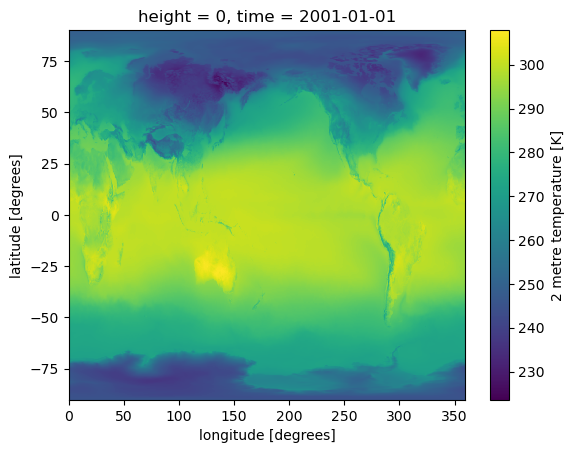

In [91]:
ds = next(data)
ds['2t'].plot()

We can regrid the data stream (the generator object itself), this gives us a new generator

In [2]:
datar = reader.regrid(data)

Correctly decoded 2t     on level 0      at 2001-01-01T00:00:00


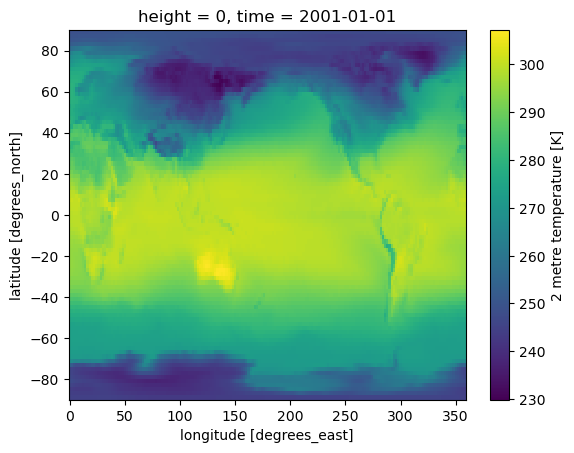

In [3]:
ds = next(datar)
ds['2t'].plot()